# Functional analysis
This notebook was used to perform the analysis of the chapter 3.4 Functional analysis and 3.2.3 Functional enrichment of clusters confirms their biological annotation 


Used to create figures: 3.9, 3.10, 3.11, S1, S2, S3, S4.

In [33]:
# import packages
import os
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import networkx as nx 
import math

## Preparation 

In [34]:
# load all cell-type regulons to obtain a list of all the TFs of interest
regulons_dir = "/home/claudia/Desktop/UGent/Thesis/networks_second/regulons/"
regulons_files = os.listdir(regulons_dir)  
open_tfs = set()

# read in regulons 
for i,f in enumerate(regulons_files): 
    with open(regulons_dir+f) as file:
        for line in file.readlines():
            line = line.split("\t")
            tf = line[0]
            open_tfs.add(tf)


In [35]:
# create a dictionary mapping gene name to gene id, will be used to translate gene names to id in the GO list 
name_to_id = dict()
with open("/home/claudia/Desktop/UGent/Thesis/enrichment/Arabidopsis_thaliana.TAIR10.48.filtered.atac.all.parsed.gtf", "r") as gtf_file:
    for line in gtf_file: 
        if not line.startswith("#"):
            extra = line.split("\t")[8]
            extra = extra.split(" ")
            for i,e in enumerate(extra):
                if e.startswith("gene_id"):
                    gene_id = extra[i+1][1:len(extra[i+1])-2]          
                if e.startswith("gene_name"):
                    gene_name = extra[i+1][1:len(extra[i+1])-2]  

            if gene_name not in name_to_id:  
                name_to_id[gene_name] = set()
            name_to_id[gene_name].add(gene_id)

In [36]:
# load file with experimental or manually curated evidence for GO terms associated with genes into the expcur_GO dataframe
input_file="/home/claudia/Desktop/UGent/Thesis/GO/ath_full_BP_expcur_red_named.txt"
expcur_GO = pd.read_csv(input_file, sep = "\t", header = None)
expcur_GO.columns = ["GO", "NAME", "ORIGIN", "GO_TERM"]
ids = []
not_found = []
for e in expcur_GO['NAME']:
    if e.upper().startswith("AT"):
        ids.append(e)
    else:
        if e in name_to_id.keys():
            ids.append(name_to_id[e]) 
        else:
            ids.append(e)
            
expcur_GO['ID'] = ids

In [37]:
# create a dictionary mapping tf to one of the three categories: KNOWN, UNKNOWN and ROOT-RELATED depending on associated GO terms.
tf_to_tftype = dict()
pattern = 'root'
for tf in open_tfs:
    if len(expcur_GO[expcur_GO.ID==tf]) > 0:
        go_term = list(expcur_GO[expcur_GO.ID==tf].GO_TERM)
        for g in go_term:
            m = re.search(pattern,g)
            if m == None:
                typee = 'KNOWN'
            else:
                typee = 'ROOT'
                break  # if they have at least one root term they're considered ROOT-RELATED

    else:
        typee = 'UNKNOWN'

    tf_to_tftype[tf] = typee


## GO Annotation
3.4.1 GO annotation of TFs and TGs

In [38]:
# Load cell-type specific regulons
miniac_TF2TG = dict()
regulons_dir = "/home/claudia/Desktop/UGent/Thesis/networks_second/regulons/"
cell_type = 'trichoblast' 

# read in regulons  
with open(regulons_dir+"regulons_"+cell_type+".txt") as file:
    for line in file.readlines():
        line = line.split("\t")
        tf = line[0]
        tg = line[1].rstrip()
        
        if tf in miniac_TF2TG:
            miniac_TF2TG[tf].append(tg)
        else:
            miniac_TF2TG[tf] = [tg]



In [39]:
# Create a dataframe mapping for all TF-TG couples: TF type, TG type and number of TGs of that type for that TF 
df_TFTG = pd.DataFrame(columns=["TF_type","TG_type", "TG_amount"])

for tf in miniac_TF2TG.keys():
    check_tgs = {"ROOT":0,"KNOWN":0,"UNKNOWN":0}
    
    for tg in miniac_TF2TG[tf]:
        if len(expcur_GO[expcur_GO.ID==tg]) > 0:
            go_term = list(expcur_GO[expcur_GO.ID==tg].GO_TERM)
            for g in go_term:
                m = re.search(pattern,g) 
                if m == None:
                    typee = 'KNOWN'
                    
                else:
                    typee = 'ROOT'
                    
        else:
            typee = 'UNKNOWN'

        
        
        check_tgs[typee] += 1

    for types in check_tgs.keys():
        df_TFTG = df_TFTG.append({
            "TF_type": tf_to_tftype[tf],
            "TG_type":  types,
            "TG_amount": check_tgs[types],
            }, ignore_index=True)

In [40]:
counter = Counter(df_TFTG.TF_type)
result = list(counter.keys())
result_values = [l/3 for l in list(counter.values())]
print(result)
print(result_values)

['KNOWN', 'ROOT', 'UNKNOWN']
[31.0, 3.0, 14.0]


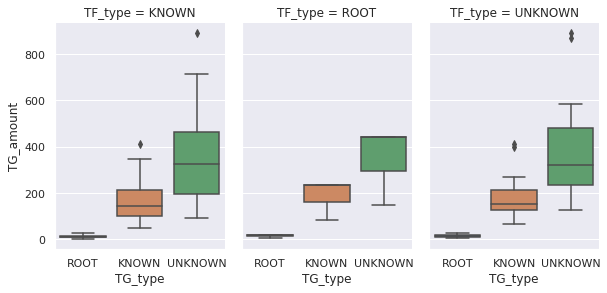

In [41]:
df_TFTG['TG_amount'] = df_TFTG['TG_amount'].astype(int)
g = sns.catplot(x="TG_type", y="TG_amount",
                col="TF_type", data=df_TFTG, kind="box",
                height=4, aspect=.7)

#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/"+cell_type+"_boxplot.svg")

## GO enrichment of TGs 

### 3.4.2 GO enrichment of TGs in regulons (for cell-type)

In [42]:
# Read in (for each cell-type) the file with enriched terms in regulons
cell_type = 'trichoblast'
enrichment_dir = "/home/claudia/Desktop/UGent/Thesis/GO/enrichment/" 
enrichment_file = cell_type+'_enrichedRegulonsGO.out' 
df = pd.DataFrame(columns=['TF','GO_TERM', 'OCCURRENCES', 'TF_TYPE'])


with open(enrichment_dir+enrichment_file) as file:
    for line in file.readlines():
        line = line.split("\t")
        tf = line[0]
        num = -math.log(float(line[3]),10) 
        term = line[9].rstrip()


        type = tf_to_tftype[tf] 
          
        df = df.append({"TF":tf,"GO_TERM":term,"OCCURRENCES":num, "TF_TYPE":type}, ignore_index=True)
 


In [43]:
# prepare for heatmap
pivoted = df.pivot(index='GO_TERM',columns='TF', values='OCCURRENCES')
pivoted = pivoted.fillna(0)
sorter = df.sort_values('TF_TYPE').TF
pivoted = pivoted.T.groupby([s for s in pivoted.T.index.values]).sum().T
pivoted = pivoted[sorter]
pivoted =  pivoted.loc[:,~pivoted.columns.duplicated()]

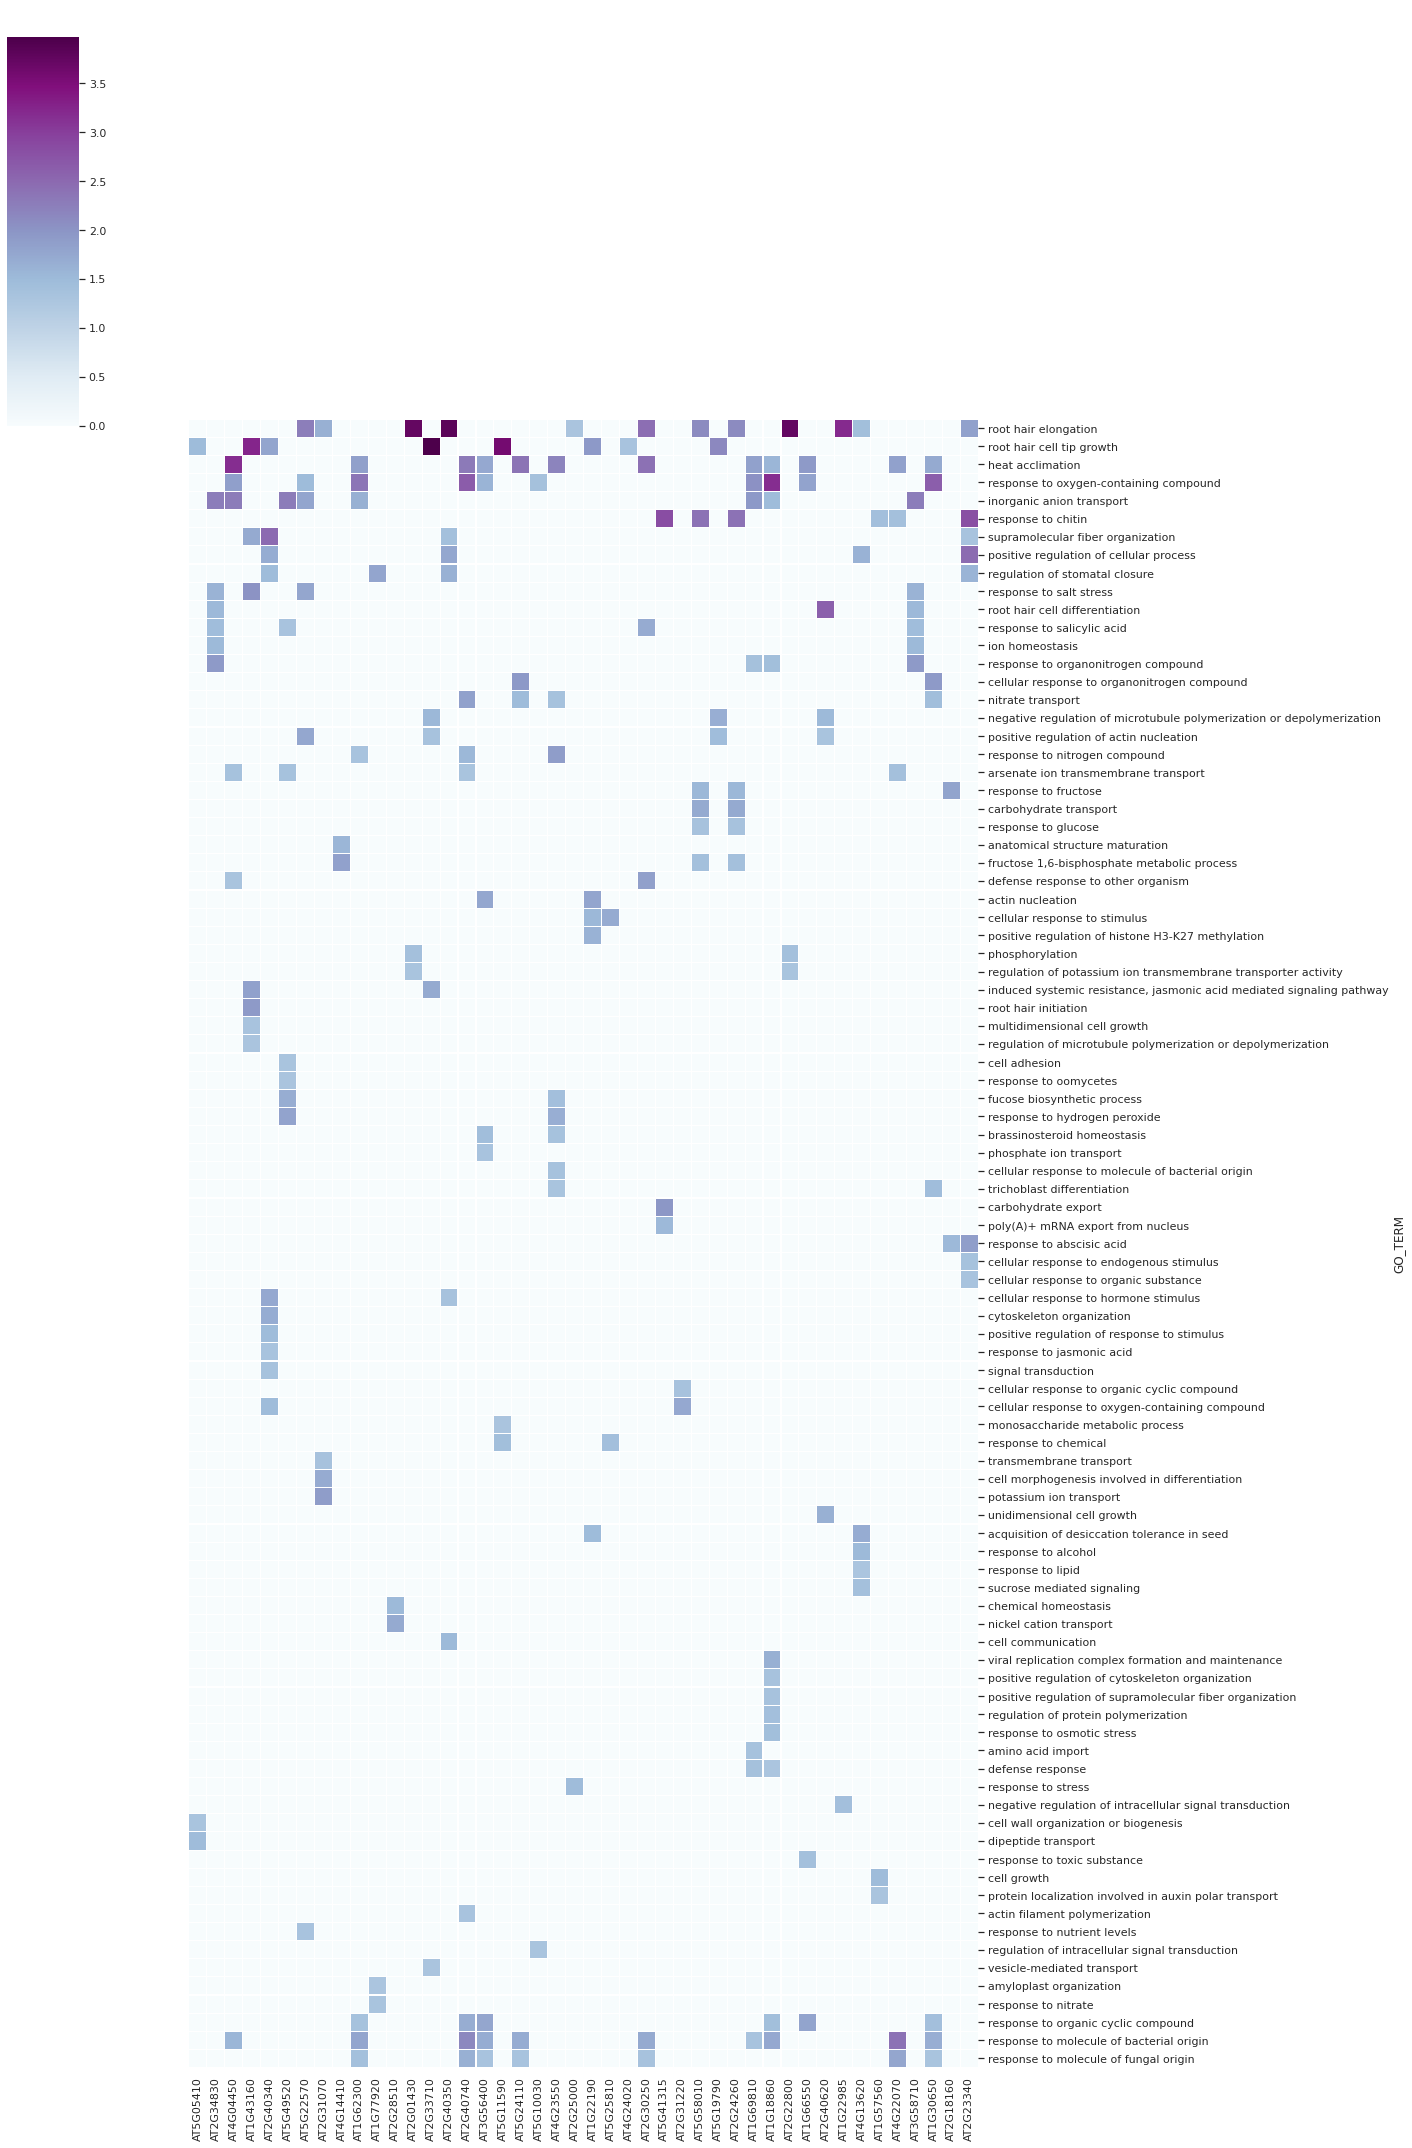

In [44]:
# plot heatmap
cg = sns.clustermap(pivoted, cmap="BuPu", linewidths=0.1,
               col_cluster=False, figsize=(20, 30) )
cg.ax_row_dendrogram.set_visible(False)

#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/"+cell_type+"_CHANGE.svg")

In [45]:
# How many TFs per category are there
lll = []
from collections import Counter
for p in pivoted.columns: 
    lll.append(list(df[df.TF==p].TF_TYPE)[0])
Counter(lll)

Counter({'KNOWN': 28, 'ROOT': 3, 'UNKNOWN': 13})

### All DARs enrichment
3.2.3 Functional enrichment of clusters confirms their biological annotation 

Enrichment of GO terms across all cell-type DARs.

In [46]:
tot="/home/claudia/Desktop/UGent/Thesis/GO/tot_enrichedRegulonsGO.out"


In [47]:
# create list of dict for each cell-type, consisting of term and associated -log10(adj. p-val)
tot_d = []
names = []
i = -1
terms = set()
with open(tot) as file:
    for line in file.readlines():
        line = line.split("\t")
        name = line[0]
        count = -math.log10(float(line[3]))
        term = line[9].rstrip()
        terms.add(term)

        if name.startswith('lateral'):
            name = 'lrc'

        if name not in names: 
            tot_d.append(dict())
            names.append(name)
            i += 1
        
        tot_d[i][term] = count

In [48]:
# put them together into one dataframe
df_tot = pd.DataFrame(columns=names)
terms = list(terms)
for t in terms:
    values = dict()
    for i,n in enumerate(names):
        if t in tot_d[i]:
            values[n] = tot_d[i][t]
        else:
            values[n] = 0

    row = pd.Series(values,name=t) 
    df_tot = df_tot.append(row)

for c in df_tot.columns:
    df_tot[c] = df_tot[c].astype(float)
    
df_tot.index = terms

#### Heatmap

/home/claudia/tools/anaconda3/envs/predmod/lib/python3.9/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


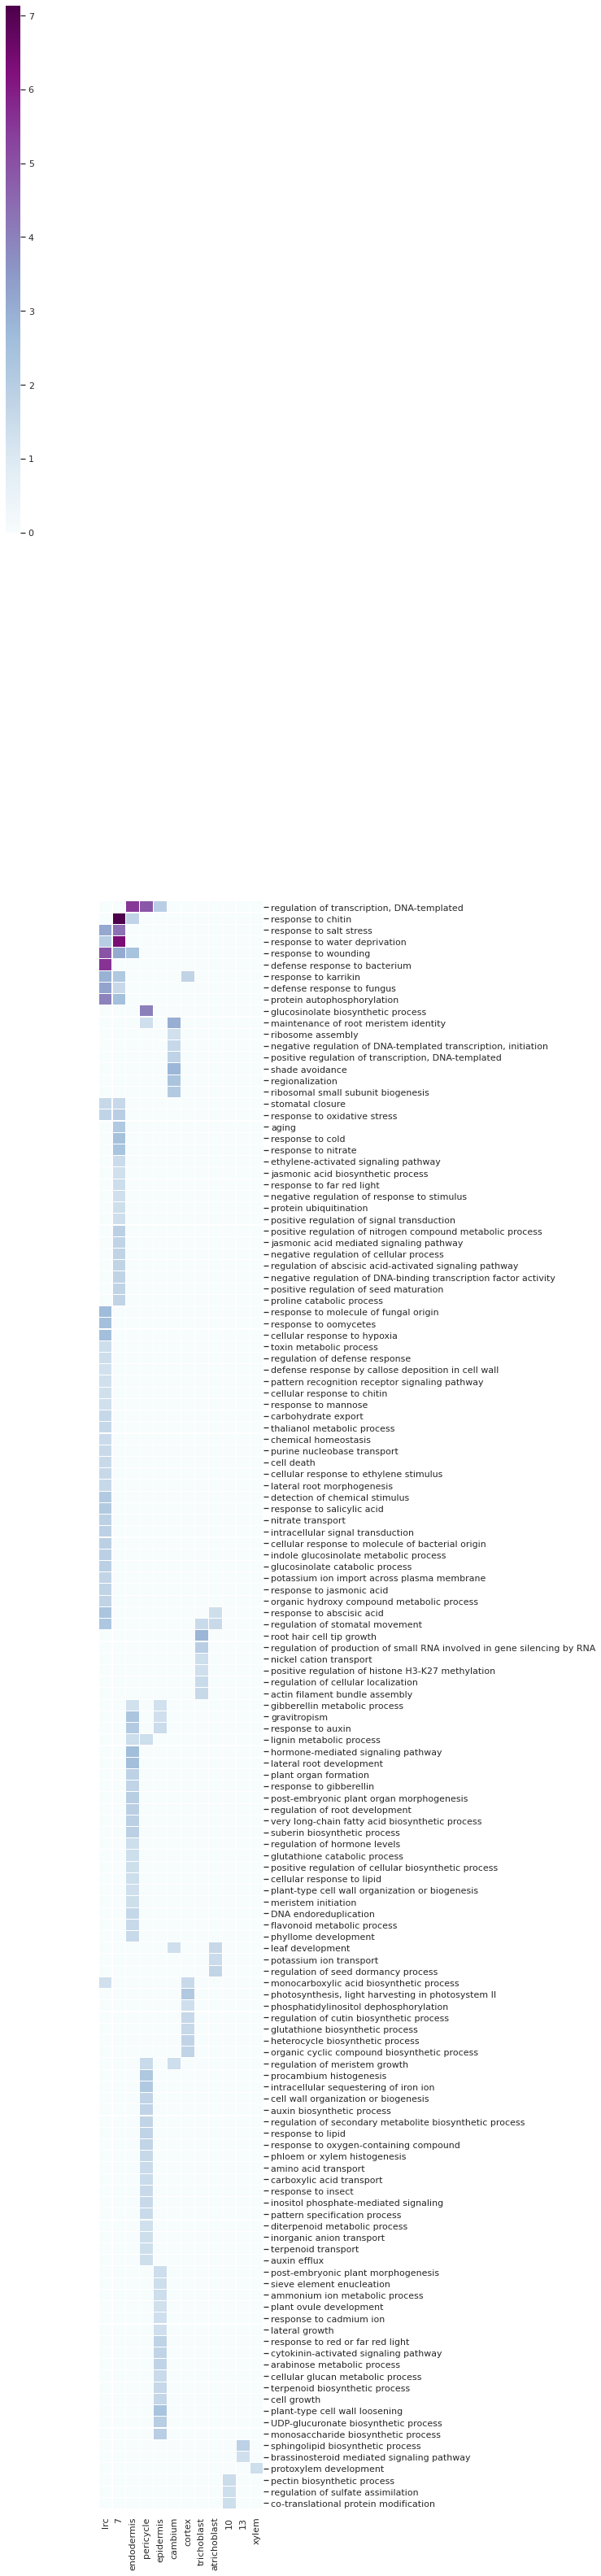

In [49]:
cg = sns.clustermap(df_tot, cmap="BuPu", linewidths=0.1, figsize=(5, 50) )
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/ALLheatmap.svg")

#### Bubbleplot

In [50]:
bubble = pd.DataFrame(columns=['celltype','pval','fc','num','term'])

with open(tot) as f:
    lines = f.readlines()
    for l in lines:
        l = l.split('\t')
        cell = l[0]
        pval = -math.log10(float(l[3]))
        fc = float(l[4])
        num = float(int(l[7]) / int(l[6]))
        term = l[-1].rstrip()

        bubble = bubble.append({"celltype":cell, "pval":pval,"fc":fc,"num":num,"term":term},ignore_index=True)



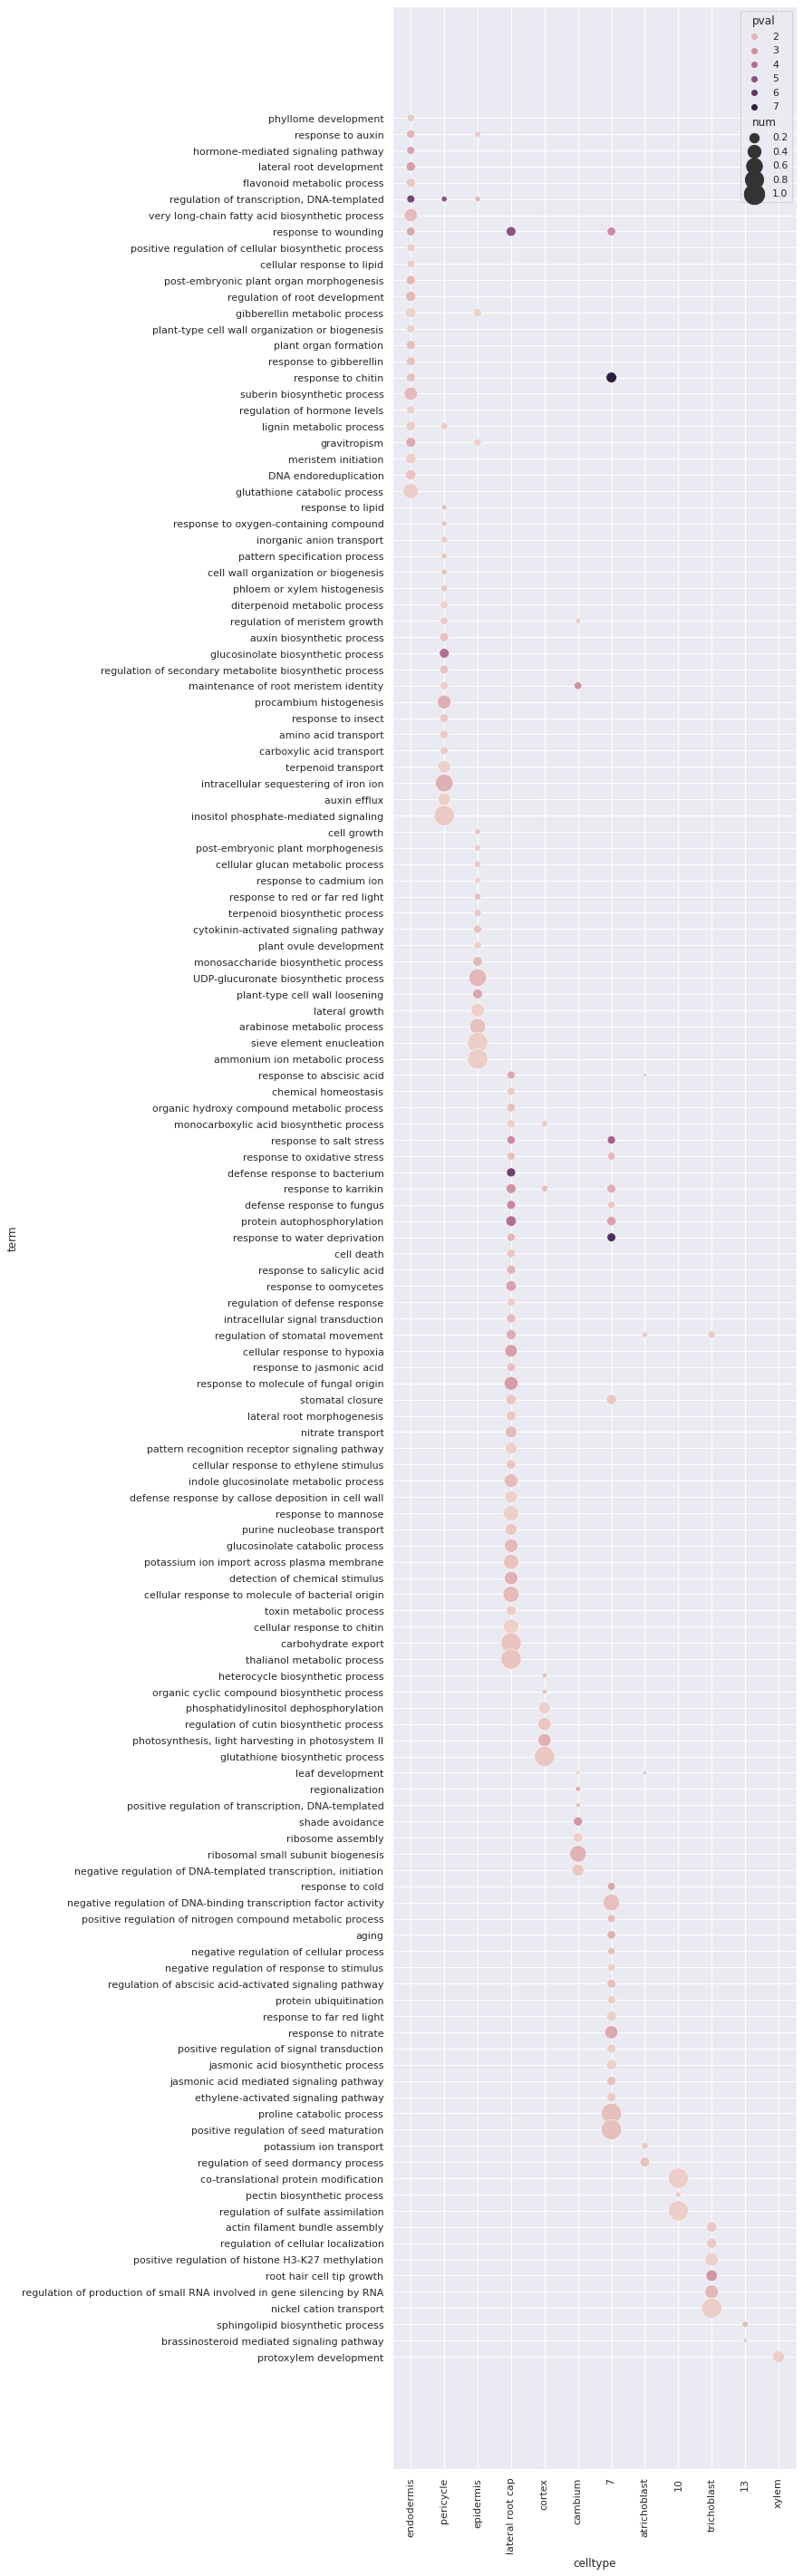

In [51]:
# data
data = bubble 

# use the scatterplot function to build the bubble map (color = -log10(p-value) ; size = effect (num of genes found with this term/all existing genes with this term) )
sns.set(rc = {'figure.figsize':(8,50)})
sns.scatterplot(data=data, x="celltype", y="term", size="num", hue="pval",sizes=(20, 500), legend=True)

plt.xticks(rotation=90)
plt.show()
#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/ALL_Bubble_leg.svg")

## Plot network of WRKY TFs in cortex

In [52]:
# read in regulons of cortex
tf2tg_cortex = {} 
with open("/home/claudia/Desktop/UGent/Thesis/networks_second/regulons/regulons_cortex.txt") as f:
    for l in f.readlines():
        l = l.split("\t")
        if l[0] in tf2tg_cortex:
            tf2tg_cortex[l[0]].append(l[1].rstrip())
        else:
            tf2tg_cortex[l[0]] = [l[1].rstrip()]


In [53]:
# Create a dictionary with TF of WRKY family
wrky = ['AT1G18860', 'AT1G30650','AT1G69810','AT5G46350']
wrky_dict =  { key:value for key,value in tf2tg_cortex.items() if key in wrky}

In [54]:
#  Filter to retain only TGs associated with `regulation of root morphogenesis`
pattern = 'regulation of root morphogenesis'
labels = dict()
filtered_wrky_dict = dict()

for k in wrky_dict:
    labels[k] = k
    filtered_wrky_dict[k] = list()
    for v in wrky_dict[k]:
        go_term = list(expcur_GO[expcur_GO.ID==v].GO_TERM)
        for g in go_term:
            m = re.search(pattern,g)
            if m == None:
                typee = 'NO'
            else:
                typee = 'ROOT'

                break

        if typee =='ROOT':
            filtered_wrky_dict[k].append(v)
            labels[v] = v


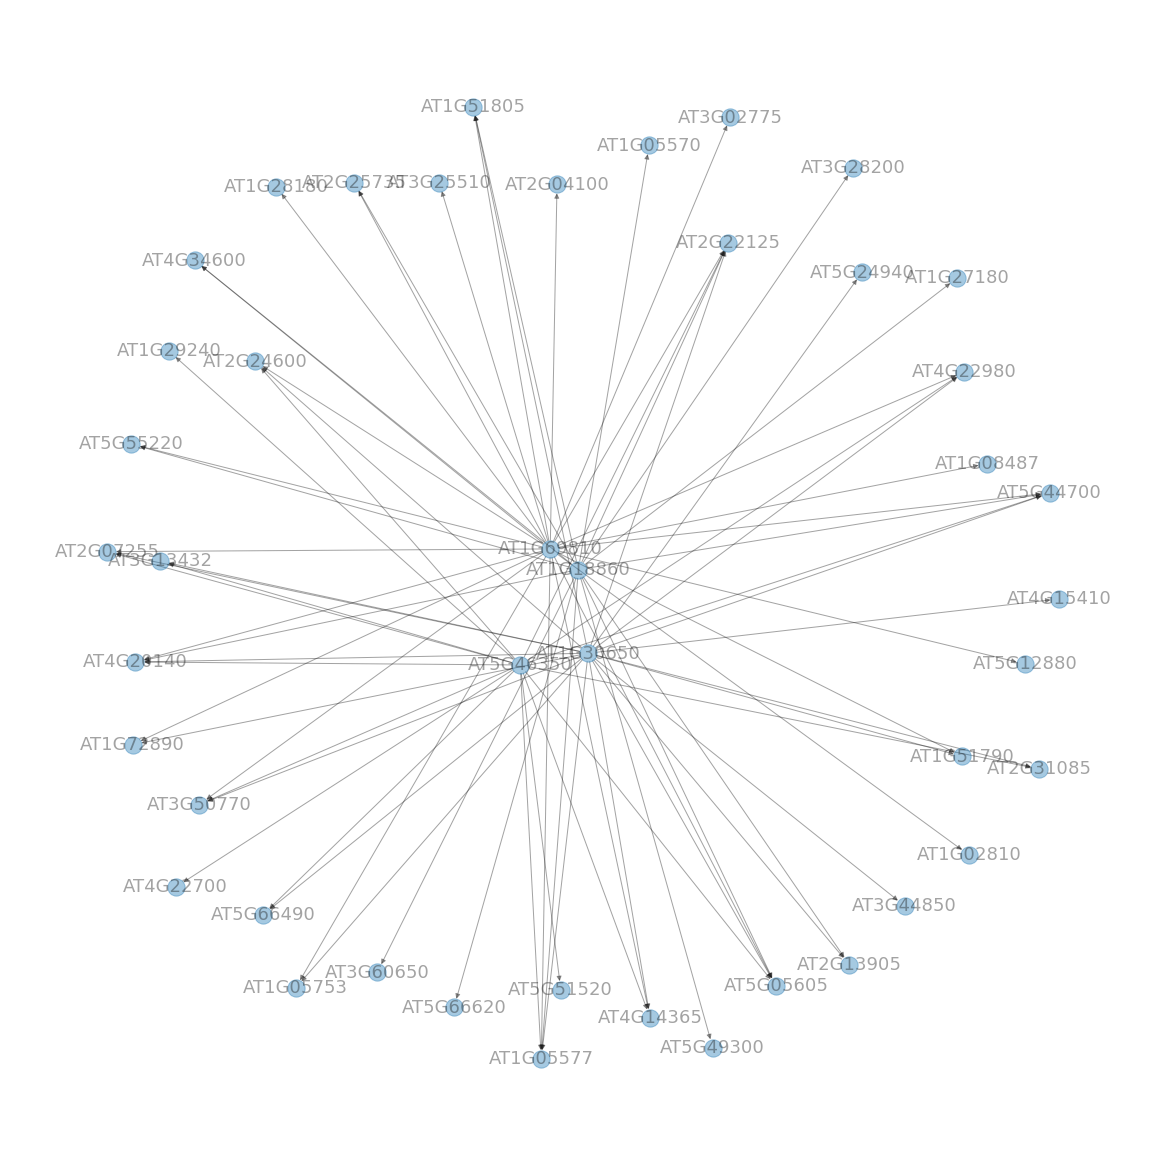

In [55]:
g = nx.DiGraph(filtered_wrky_dict)

# draw graph
plt.figure(figsize=(16,16))
pos = nx.spring_layout(g, scale=2) 
nx.draw(g, font_size=18,
        alpha=0.4,arrows=True,
        pos=pos, labels=labels)

#plt.savefig("/home/claudia/Desktop/UGent/Thesis/figures/network.svg")